In [1]:
from collections import defaultdict
import glob
from itertools import groupby
import operator
import os
import re

import numpy as np
import pandas as pd
import pickle
import random
import sparse
#import tensorly as tl
#import tensorly.decomposition as decomp
import sktensor
import urllib3
#import wget

import matplotlib.pyplot as plt
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

import logging
logging.basicConfig(level=logging.INFO, 
                    format='%(levelname)-8s [%(lineno)d] %(message)s')

if not os.path.exists('cp_orth.py'):
    wget.download('http://web.stanford.edu/~vsharan/cp_orth.py')
from cp_orth import orth_als

/home/makrai/tool/python/miniconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"
DEBUG    [211] Loaded backend module://ipykernel.pylab.backend_inline version unknown.


Populating the interactive namespace from numpy and matplotlib


In [2]:
names = ['lemma', 'token_freq', 'pos', 'doc_freq', 'normalized']
prevlex = pd.read_csv('/home/makrai/repo/prevlex/PrevLex.txt', sep='\t', header=None, names=names)
prevlex.head()

,lemma,token_freq,pos,doc_freq,normalized
0,abba+hagy,9496,FIN,1258,abba+hagy
1,abba+marad,1277,FIN,620,abba+marad
2,abba+hagyat,45,FIN,41,abba+hagyat
3,abba+fejez,27,UNKNOWN,24,abba+fejez
4,abba+szakad,3,UNKNOWN,3,abba+szakad


In [3]:
class keydefault_dict(dict):
    def __missing__(self, key):
        return ('', key)

def get_prev_verb():
    prev_verb = keydefault_dict()
    for prev_plus_verb in prevlex.lemma:
        prev, verb = prev_plus_verb.split('+')
        prev_verb[prev+verb] = (prev, verb)
    return prev_verb

In [4]:
projdir = '/mnt/permanent/home/makrai/project/verb-tensor'

In [2]:
def show_expers(feature='exectimes'):
    tabular = []
    mx = []
    for filen in glob.glob(os.path.join(projdir, 'prev_sep/decomp_*.pkl')):
        _, cutoff, dim = os.path.splitext(filen)[0].rsplit('_', 2)
        cutoff, dim = map(int, (cutoff, dim))
        ktensor, fit, n_iterations, exectimes = pickle.load(open(filen, mode='rb'))
        tabular.append((cutoff, dim, ktensor.shape))
        mx.append([cutoff, dim, sum(exectimes)/60/60])
    mx = np.array(mx)
    print('\n'.join(map(str, sorted(tabular))))
    plt.scatter(np.array(mx).T[0], mx.T[1], c=mx.T[2])
    plt.colorbar()
    plt.xscale('log')

DEBUG    [507] locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f8d1dc8e550>
DEBUG    [536] Using auto colorbar locator on colorbar
DEBUG    [537] locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f8d1dc8e550>
DEBUG    [693] Setting pcolormesh
DEBUG    [2515] update_title_pos
DEBUG    [2157] vmin 803.4067316620622 vmax 167059.29562924776
DEBUG    [2212] ticklocs array([1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07])
DEBUG    [2157] vmin 803.4067316620622 vmax 167059.29562924776
DEBUG    [2212] ticklocs [20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 200.0, 300.0, 400.0, 500.0, 600.0, 700.0, 800.0, 900.0, 2000.0, 3000.0, 4000.0, 5000.0, 6000.0, 7000.0, 8000.0, 9000.0, 20000.0, 30000.0, 40000.0, 50000.0, 60000.0, 70000.0, 80000.0, 90000.0, 200000.0, 300000.0, 400000.0, 500000.0, 600000.0, 700000.0, 800000.0, 900000.0, 2000000.0, 3000000.0, 4000000.0, 5000000.0, 6000000.0, 7000000.0, 8000000.0, 9000000.0, 20000000.0, 30000000.0, 40000000.0, 50000000.

(1024, 50, (2489, 67, 1358, 1196))
(2048, 2, (1251, 58, 898, 579))
(2048, 3, (1251, 58, 898, 579))
(2048, 5, (1251, 58, 898, 579))
(2048, 10, (1251, 58, 898, 579))
(2048, 25, (1251, 58, 898, 579))
(2048, 50, (1251, 58, 898, 579))
(4096, 2, (622, 48, 616, 243))
(8192, 2, (278, 33, 384, 101))
(16384, 2, (87, 25, 219, 43))
(32768, 2, (24, 16, 120, 16))
(32768, 3, (24, 16, 120, 16))
(32768, 5, (24, 16, 120, 16))
(32768, 10, (24, 16, 120, 16))
(65536, 2, (10, 15, 48, 9))
(65536, 3, (10, 15, 48, 9))
(65536, 4, (10, 15, 48, 9))
(65536, 5, (10, 15, 48, 9))
(131072, 2, (3, 9, 19, 5))
(131072, 3, (3, 9, 19, 5))


DEBUG    [2515] update_title_pos
DEBUG    [2157] vmin 803.4067316620622 vmax 167059.29562924776
DEBUG    [2212] ticklocs array([1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07])
DEBUG    [2515] update_title_pos
DEBUG    [2157] vmin 803.4067316620622 vmax 167059.29562924776
DEBUG    [2212] ticklocs array([1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07])
DEBUG    [2157] vmin 803.4067316620622 vmax 167059.29562924776
DEBUG    [2212] ticklocs [20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 200.0, 300.0, 400.0, 500.0, 600.0, 700.0, 800.0, 900.0, 2000.0, 3000.0, 4000.0, 5000.0, 6000.0, 7000.0, 8000.0, 9000.0, 20000.0, 30000.0, 40000.0, 50000.0, 60000.0, 70000.0, 80000.0, 90000.0, 200000.0, 300000.0, 400000.0, 500000.0, 600000.0, 700000.0, 800000.0, 900000.0, 2000000.0, 3000000.0, 4000000.0, 5000000.0, 6000000.0, 7000000.0, 8000000.0, 9000000.0, 20000000.0, 30000000.0, 40000000.0, 50000000.0, 60000000.0, 70000000.0, 80000000.0, 90000000.0]
DEBUG    [2157] vmin 803.406731662062

DEBUG    [2157] vmin 803.4067316620622 vmax 167059.29562924776
DEBUG    [2212] ticklocs array([1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07])
DEBUG    [2157] vmin 803.4067316620622 vmax 167059.29562924776
DEBUG    [2212] ticklocs [20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 200.0, 300.0, 400.0, 500.0, 600.0, 700.0, 800.0, 900.0, 2000.0, 3000.0, 4000.0, 5000.0, 6000.0, 7000.0, 8000.0, 9000.0, 20000.0, 30000.0, 40000.0, 50000.0, 60000.0, 70000.0, 80000.0, 90000.0, 200000.0, 300000.0, 400000.0, 500000.0, 600000.0, 700000.0, 800000.0, 900000.0, 2000000.0, 3000000.0, 4000000.0, 5000000.0, 6000000.0, 7000000.0, 8000000.0, 9000000.0, 20000000.0, 30000000.0, 40000000.0, 50000000.0, 60000000.0, 70000000.0, 80000000.0, 90000000.0]
DEBUG    [2515] update_title_pos
DEBUG    [2515] update_title_pos
DEBUG    [2157] vmin 803.4067316620622 vmax 167059.29562924776
DEBUG    [2212] ticklocs array([1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07])
DEBUG    [2157] vmin 803.406731662062

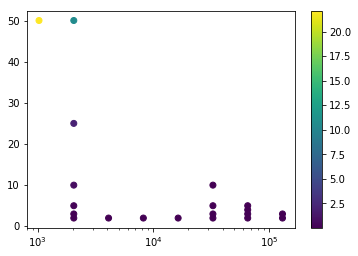

In [5]:
show_expers()

In [10]:
def rand_elem(list1):
    return list1[np.random.randint(0, len(list1))]

In [11]:
%time decomp(2**9, 50)

INFO     [2] (512, 50)
INFO     [2] Reweighting: log
INFO     [6] Loading tensor from /mnt/permanent/home/makrai/project/verb-tensor/prev_sep/tensor_sktensor_512.pkl
DEBUG    [8] (4598, 79, 1997, 2183)
ERROR    [14] 
Traceback (most recent call last):
  File "<ipython-input-7-faa17104d271>", line 9, in decomp
    result = orth_als(vtensor, dim)
  File "/home/makrai/repo/verb-tensor/cp_orth.py", line 152, in orth_als
    U = _init(ainit, X, N, rank, dtype)
  File "/home/makrai/repo/verb-tensor/cp_orth.py", line 254, in _init
    Uinit[n] = array(nvecs(X, n, rank), dtype=dtype)
  File "/home/makrai/tool/python/miniconda3/lib/python3.7/site-packages/sktensor/core.py", line 276, in nvecs
    Y = Xn.dot(Xn.T)
  File "/home/makrai/tool/python/miniconda3/lib/python3.7/site-packages/scipy/sparse/base.py", line 364, in dot
    return self * other
  File "/home/makrai/tool/python/miniconda3/lib/python3.7/site-packages/scipy/sparse/base.py", line 482, in __mul__
    return self._mul_sparse_matrix

CPU times: user 1.24 s, sys: 496 ms, total: 1.74 s
Wall time: 1.38 s
